In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

# 1. Exploración de datos


In [159]:
df_data = pd.read_excel(r"Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


## 1.1 Calidad de datos

### 1.1.1 Completitud

Se observa que no hay valores nulos en el dataset, hay 2424 filas y 2 columnas, y para cada columna ha 2424 valores no nulos. La columna `textos` es de tipo objeto (string) y la columna `labels` es de tipo entero (int64).


In [160]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [161]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [162]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [163]:
# Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [164]:
# Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [165]:
# verificar si hay textos con strings vacíos
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

Número de textos vacíos: 0


### 1.1.2 Unicidad

Se observa que no hay duplicados en el dataset.


In [166]:
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [167]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.3 Validez

Revisar que todas las opiniones estén en el mismo idioma (español) y que las etiquetas sean del conjunto {1, 3, 4}.


In [168]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [169]:
# clases en el datset
df["labels"].unique()

array([4, 3, 1], dtype=int64)

Todos los textos están en español, no se encontraron textos en otros idiomas.


In [170]:
df = df.drop(columns=["language"])

### 1.1.4 Consistencia


In [171]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

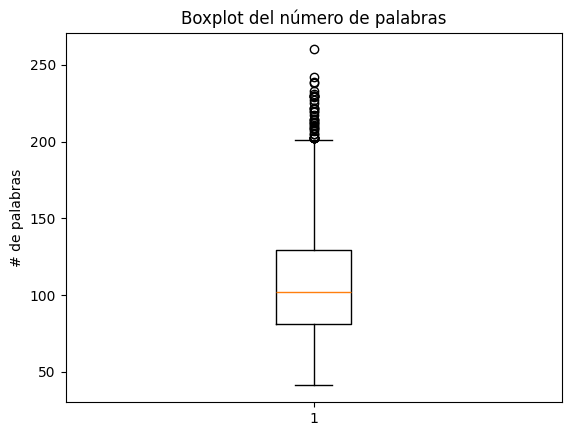

In [172]:
plt.boxplot(df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

Se observan outliers en textos que tienen una alta cantidad de palabras.


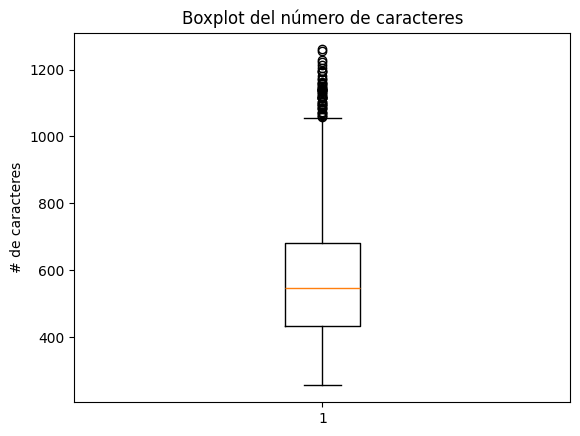

In [173]:
df["character_count"] = df["textos"].apply(
    lambda x: len(str(x.replace(" ", "").strip()))
)
plt.boxplot(df["character_count"])
plt.title("Boxplot del número de caracteres")
plt.ylabel("# de caracteres")
plt.show()
df = df.drop(columns=["character_count"])

# 2. Preparación de datos y continuación de la exploración


## 2.1 Tokenización y limpieza de texto

1. Definir función para limpiar y tokenizar el texto.
2. Aplicar la función a la columna "textos" y almacenar el resultado en una nueva columna.
3. Crear un dataframe de palabras tokenizadas para análisis posterior.

Nota: se decide no realizar stemming o lematización para preservar una mayor interpretabilidad de los resultados.


In [174]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()


def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [
        spanish_stemmer.stem(token) if stem else token
        for token in tokens
        if token not in stop_words
    ]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [175]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,93,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


## 2.2 Exploración de distribución de datos


### 2.2.1 Análisis de balance de clases


In [176]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


In [177]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

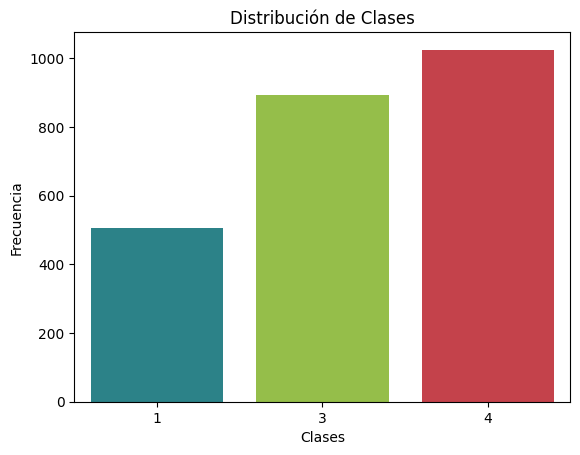

In [178]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

Las clases 4 y 3 tienen una mayor representación en el dataset, mientras que las clases 1 tiene una representación menor.


### 2.2.2 Análisis de la distribución del número de palabras por clase


Se verifica que la diferencia entre las medias de la longitud de los textos de cada clase no sea significativa con una prueba _ANOVA_.


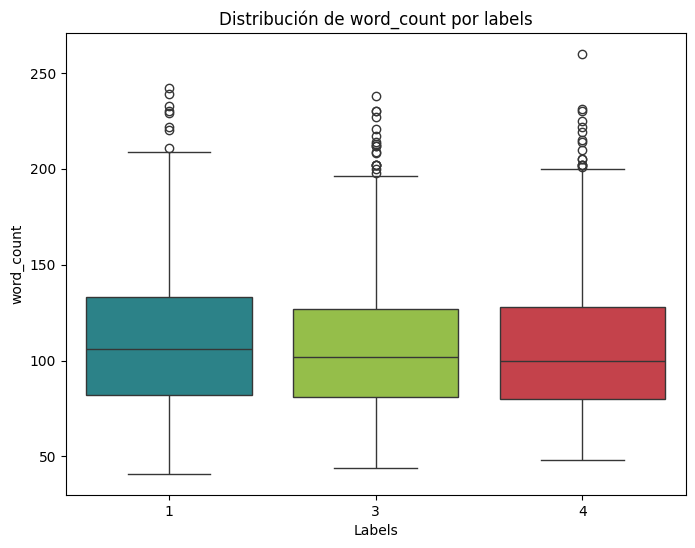

In [179]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="labels", y="word_count", data=df, palette=colors, hue="labels", legend=False
)

plt.title("Distribución de word_count por labels")
plt.xlabel("Labels")
plt.ylabel("word_count")
plt.show()

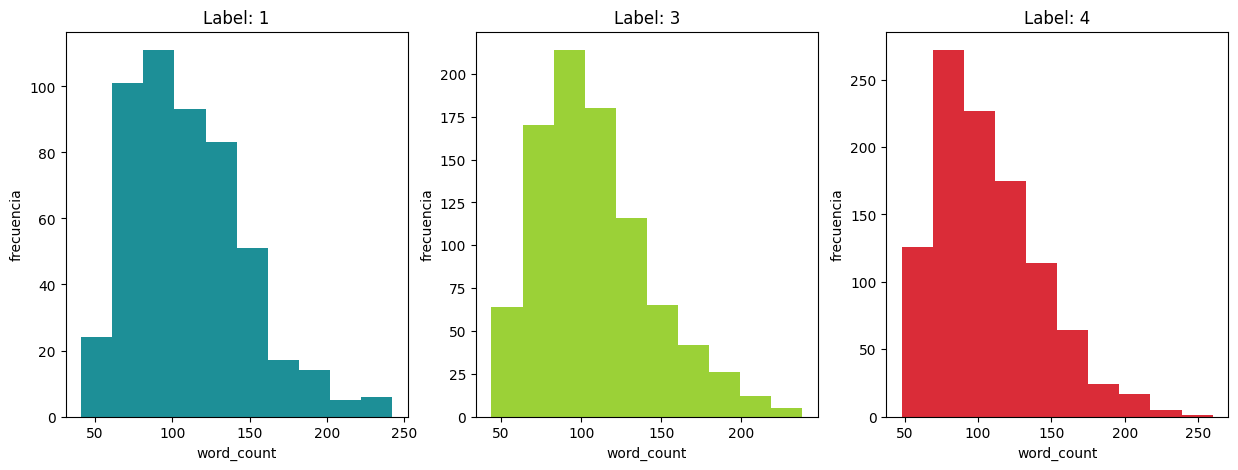

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(sorted(df["labels"].unique())):
    ax[i].hist(df[df["labels"] == label]["word_count"], color=colors[label])
    ax[i].set_xlabel("word_count")
    ax[i].set_ylabel("frecuencia")
    ax[i].set_title(f"Label: {label}")


plt.show()

Hipótesis Nula ($H_0$): No hay diferencia en la media de la variable numérica `word_count` para todos los grupos: $ \mu_1 = \mu_3 = \mu_4 $.

Hipótesis Alterna ($H_1$): Hay una diferencia en la media de la variable numérica `word_count` para al menos uno de los grupos: $ \mu_i \neq \mu_j $ para al menos un par $(i, j)$, donde $i, j \in \{1, 3, 4\}$ y $i \neq j$.


In [181]:
label1_group = normalized_df[normalized_df["labels"] == 1]["word_count"]
label3_group = normalized_df[normalized_df["labels"] == 3]["word_count"]
label4_group = normalized_df[normalized_df["labels"] == 4]["word_count"]

f_statistic, p_value = f_oneway(label1_group, label3_group, label4_group)

print("Resultados del Test ANOVA:")
print("=" * 30)
print(f"Estadístico F: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print("=" * 30)

alpha = 0.05

print("Interpretación:")
if p_value < alpha:
    print(f"p-value ({p_value:.4f}) es menor que {alpha}.")
    print("Se rechaza la hipótesis nula (H0).")
    print(
        "Conclusión: Existe una diferencia estadísticamente significativa en la media de 'word_count' de al menos uno de los grupos."
    )
else:
    print(f"p-value ({p_value:.4f}) es mayor que {alpha}.")
    print("No se puede rechazar la hipótesis nula (H0).")
    print(
        "Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos."
    )

Resultados del Test ANOVA:
Estadístico F: 1.8812
P-value: 0.1526
Interpretación:
p-value (0.1526) es mayor que 0.05.
No se puede rechazar la hipótesis nula (H0).
Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos.


Dado el resultado de la prueba _ANOVA_ de una vía con $\alpha = 0.05$, no se puede rechazar la hipótesis nula, lo que indica que no hay evidencia suficiente para afirmar que existen diferencias significativas en la media de la variable `word_count` entre las diferentes clases.

De este modo, se tiene claridad en que la longitud de los textos no introduce un sesgo significativo en el análisis de las opiniones clasificadas en las diferentes clases.


### 2.2.3 Distribución del número de palabras en todo el dataset


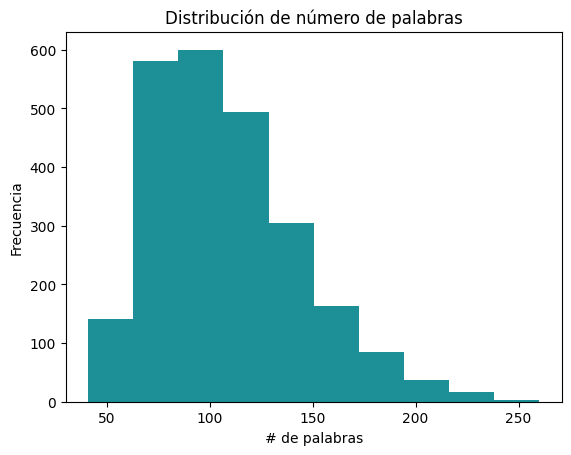

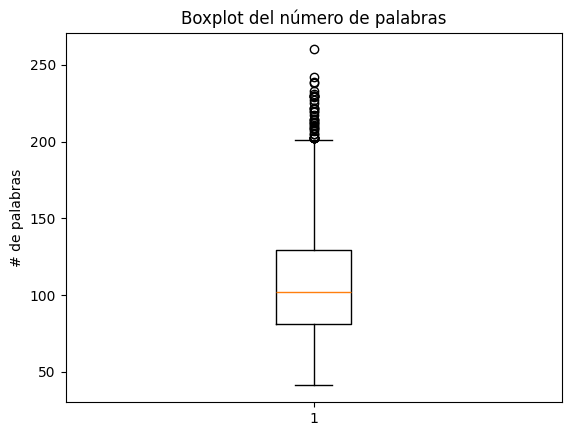

In [182]:
plt.hist(normalized_df["word_count"], color="#1D8F97")
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.boxplot(normalized_df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

## 2.3 Exploración de las palabras más frecuentes y representativas por clase


Se quiere saber cuáles son las palabras más frecuentes en todo el dataset y por clase.


### 2.3.1 Palabras más frecuentes en todo el dataset


,word,frequency
0,salud,1108
1,pobreza,1020
2,educación,995
3,países,963
4,atención,900
5,estudiantes,742
6,ocde,587
7,escuelas,586
8,años,560
9,servicios,549


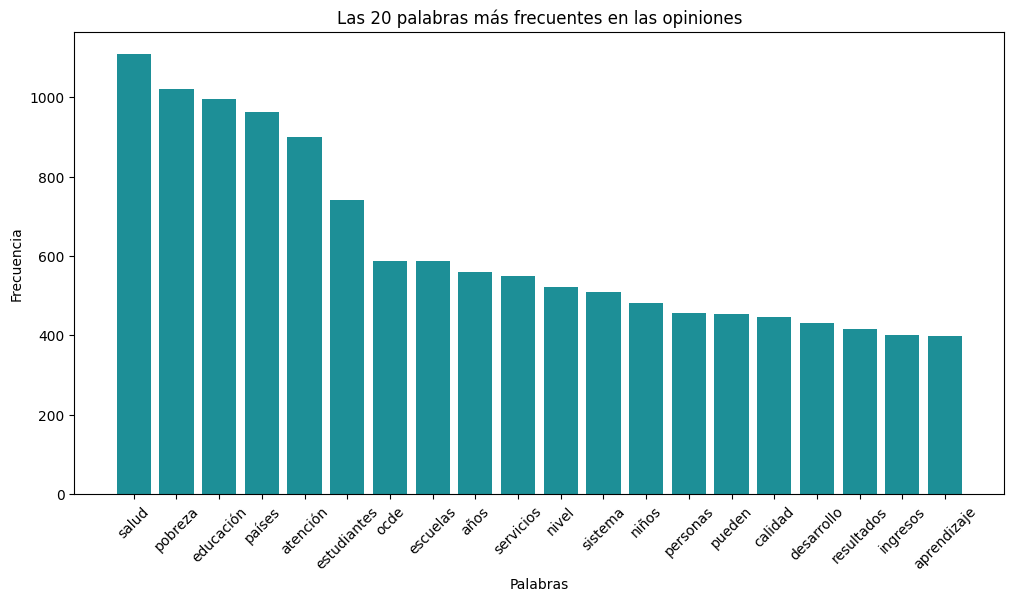

In [183]:
all_tokens = [token for tokens_list in normalized_df["tokens"] for token in tokens_list]

word_counts = Counter(all_tokens)

# Obtener las n palabras más comunes
n_words = 20
most_common_words = word_counts.most_common(n_words)

freq_df = pd.DataFrame(most_common_words, columns=["word", "frequency"])

display(freq_df)

# Graficar las palabras más frecuentes
plt.figure(figsize=(12, 6))
plt.bar(freq_df["word"], freq_df["frequency"], color="#1D8F97")
plt.xticks(rotation=45)
plt.title(f"Las {n_words} palabras más frecuentes en las opiniones")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

Estos son las palabras más frecuentes en todo el dataset. Pero ¿tienen frecuencias similares en cada clase? ¿O hay palabras que son más frecuentes en una clase que en otra?


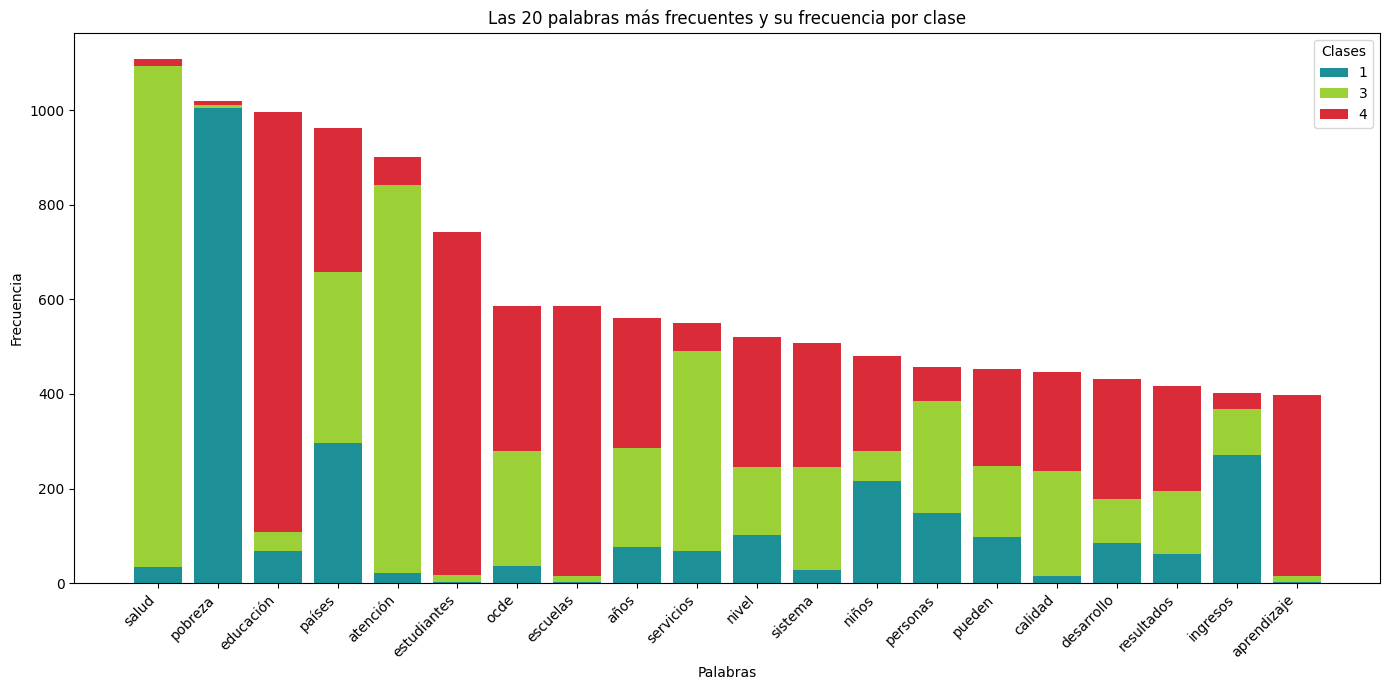

In [184]:
top_words = [word for word, count in most_common_words]

classes = sorted(normalized_df["labels"].unique())  # [1, 3, 4]
class_freq_data = {}

for label in classes:
    class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(class_tokens)

    # por cada una de las palabras del top, encontrar su frecuencia en la clase
    class_freq_data[label] = [class_word_counts.get(word, 0) for word in top_words]

plot_df = pd.DataFrame(class_freq_data, index=top_words)

fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(top_words))  # iniciar la base de las barras en 0

for class_label, frequencies in plot_df.items():
    ax.bar(
        plot_df.index,
        frequencies,
        bottom=bottom,
        label=class_label,
        color=colors[class_label],
    )
    # Añadir la frecuencia a la base de la siguiente iteración
    bottom += frequencies.values

ax.set_title(f"Las {n_words} palabras más frecuentes y su frecuencia por clase")
ax.set_xlabel("Palabras")
ax.set_ylabel("Frecuencia")

ax.set_xticks(ax.get_xticks())  # This can help avoid a UserWarning
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(title="Clases")
plt.tight_layout()
plt.show()

Algunas palabras como "paises" y "pueden" parecen tener frecuencias similares en todas las clases, pero se observa que la mayoría de las palabras más frecuentes tienen distribuciones de frecuencia diferentes en cada clase. Por ejemplo, la palabra "salud" en mucho más frecuente en la clase 3, sobre el ODS de **Salud y Bienestar**, mientras que palabras como "educacion" y "estudiantes" son más frecuentes en la clase 4, sobre el ODS de **Educación de Calidad**. Esto sugiere que ciertas palabras están más asociadas con opiniones de ciertas clases, lo que podría ser útil para la clasificación de textos.


### 2.3.2 Palabras más frecuentes por clase


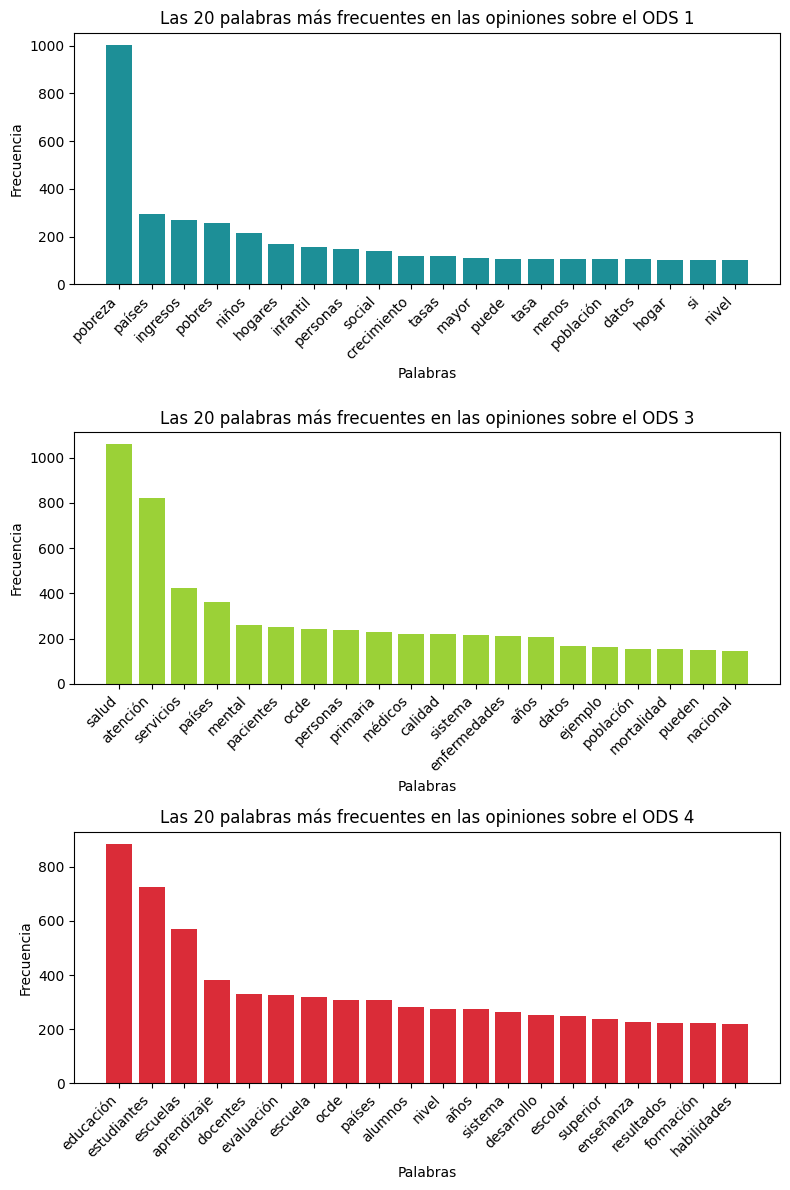

In [185]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)

    label_freq_df = pd.DataFrame(top_class_words_counts, columns=["word", "frequency"])

    # Graficar las palabras más frecuentes para la clase
    ax[i].bar(label_freq_df["word"], label_freq_df["frequency"], color=colors[label])
    ax[i].set_xticks(ax[i].get_xticks())
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

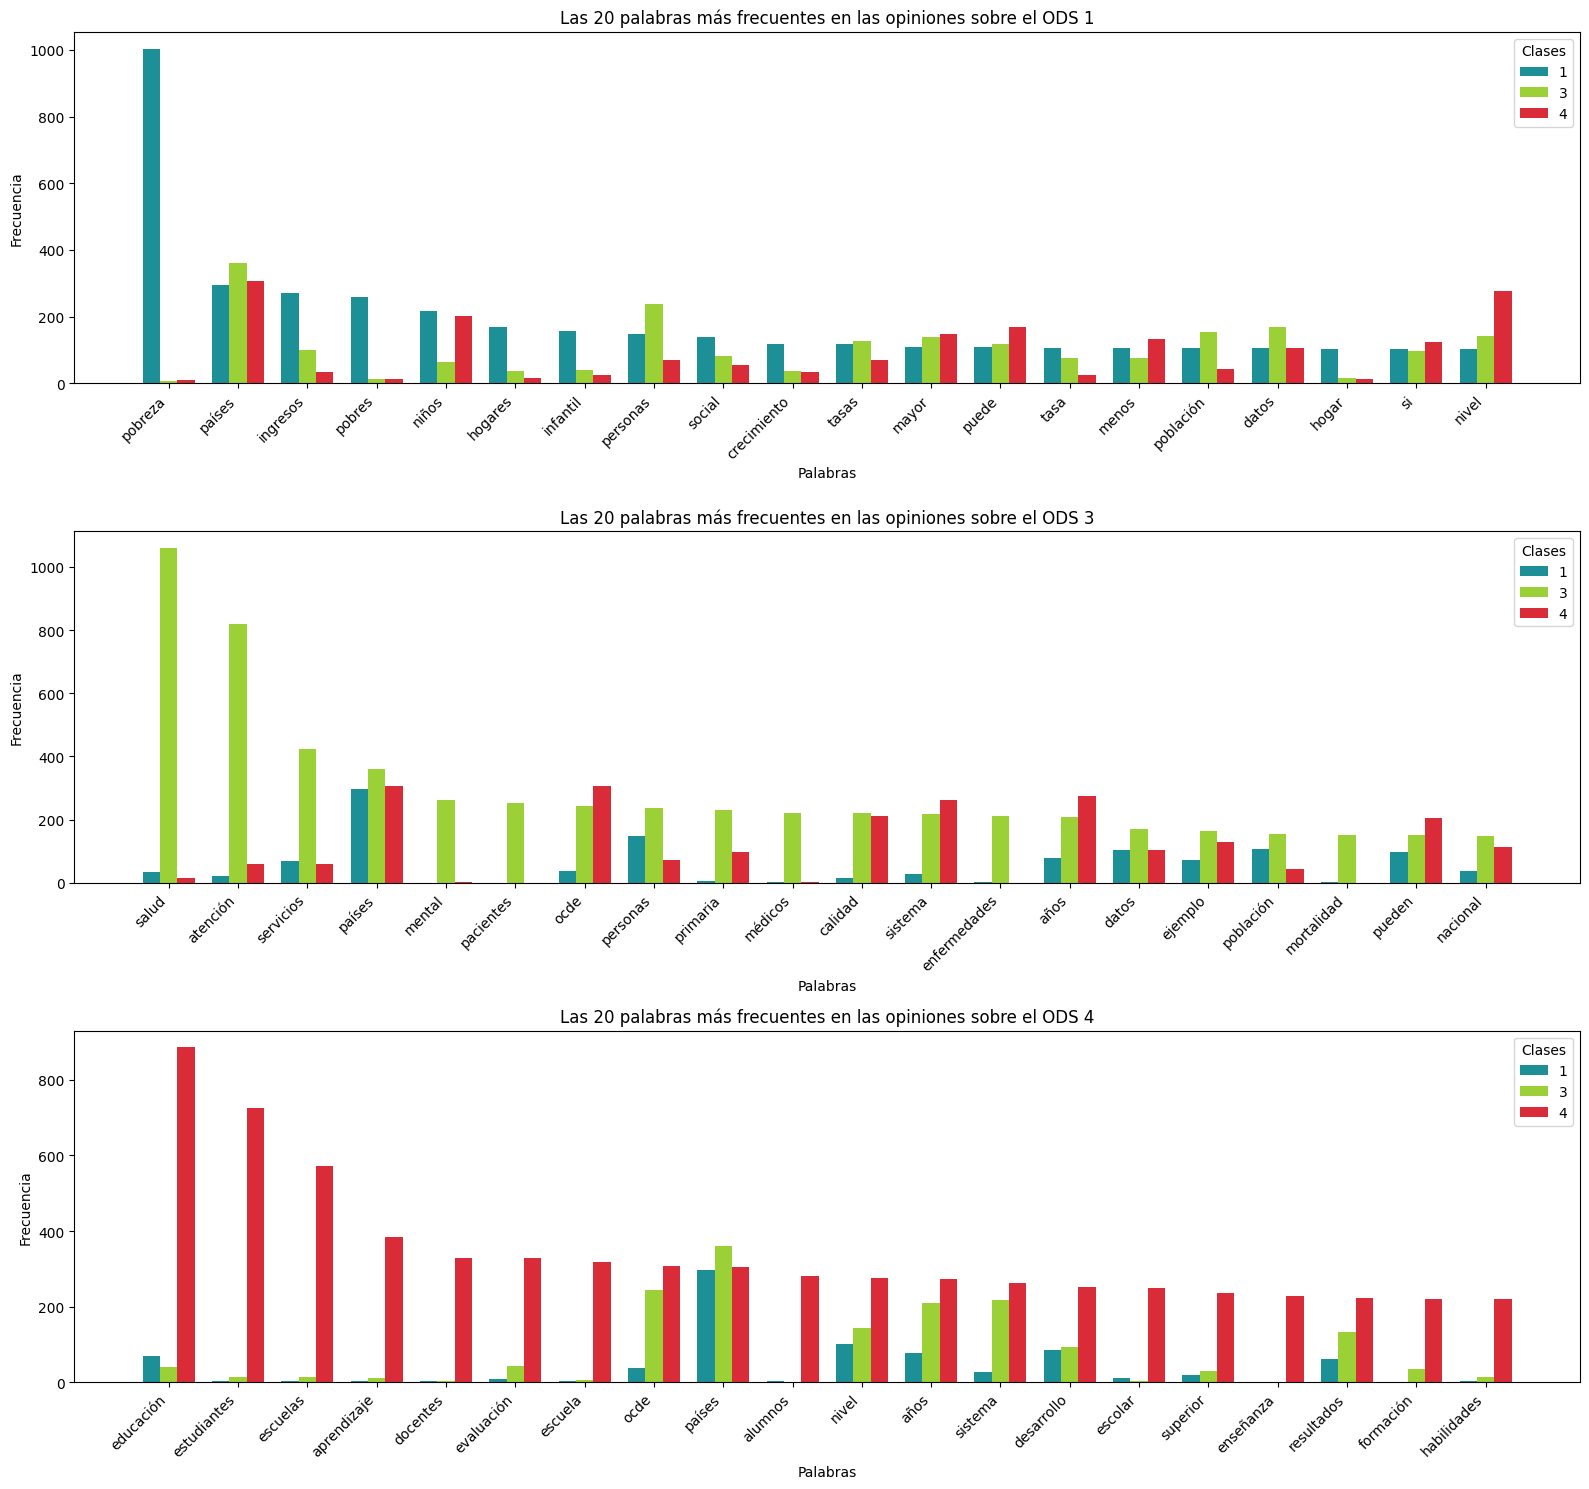

In [186]:
fig, ax = plt.subplots(3, 1, figsize=(16, 15))
bar_width = 0.25
n_classes = len(classes)
for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)

    class_top_words = [word for word, count in top_class_words_counts]
    class_freq_data = {}

    for label2 in classes:
        # por cada una de las palabras del top, encontrar su frecuencia en las clases
        class_tokens = [
            token
            for tokens_list in normalized_df[normalized_df["labels"] == label2][
                "tokens"
            ]
            for token in tokens_list
        ]

        class_word_counts = Counter(class_tokens)

        class_freq_data[label2] = [
            class_word_counts.get(word, 0) for word in class_top_words
        ]

    label_freq_df = pd.DataFrame(class_freq_data, index=class_top_words)
    x_positions = np.arange(len(label_freq_df.index))
    # Graficar las palabras más frecuentes para la clase
    for j, class_name in enumerate(label_freq_df.columns):
        offset = bar_width * (j - (n_classes - 1) / 2.0)
        ax[i].bar(
            x_positions + offset,
            label_freq_df[class_name],
            width=bar_width,
            label=class_name,
            color=colors[class_name],
        )
    ax[i].set_xticks(x_positions)
    ax[i].set_xticklabels(label_freq_df.index, rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")
    ax[i].legend(title="Clases")

plt.tight_layout()
plt.show()

Esta visualización nos permite entender que para los ODS 3 y 4, las opiniones contienen palabras específicas relacionadas con los temas de salud y educación, respectivamente, pues al observar que las frecuencias de la clase son visiblemente superiores a las de las otras clases, se puede inferir que estas palabras son más representativas y distintivas para esas clases en particular. Por otro lado, para el ODS 1, aunque tiene palabras frecuentes, son menores en número y en frecuencia comparadas con las otras clases, lo que sugiere que las opiniones relacionadas con la pobreza pueden ser más diversas en términos de vocabulario utilizado y presentar una mayor dificultad para su clasificación.


In [187]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,93,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


## 2.4 División del dataset en entrenamiento y prueba


Finalmente, antes de empezar con los métodos de extracción de features se realiza el split entre datos de entrenamiento y test con el fin de no producir _data snooping_ y que el procesamiento sea el adecuado.


In [188]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Extracción de features

Para el proceso de extracción de features se utilizaron múltiples métodos con los cules se comparan los modelos que se realizan.


## 3.1 N-M Gramas

Se propone hacer un N-M Grama para extraer características del texto, con el fin de capturar secuencias de palabras que puedan ser relevantes para la clasificación.


En primer lugar se hace una prueba de 1-3 Gramas que clasifica tanto por unigramas, bigramas y trigramas que permite entender la dispersión general de su comportamiento. Este revisa si hay similitudes entre el BOW ya generado, o si agregar palabras concatenadas más largas permite mejorar la clasificación.

Asimismo, se hace el análisis sobre solo las palabras más utilizadas para ahorrar tiempo de computo, y para eliminar sesgos que pueden existir dentro de la clasificación


In [189]:
n_top_words = 50
top_words = [word for word, count in word_counts.most_common(n_top_words)]
bv = CountVectorizer(vocabulary=top_words, ngram_range=(1, 3))
bv_matrix = bv.fit_transform(normalized_df["tokenized_text"].tolist())
vocab = bv.get_feature_names_out()
print(vocab)
pd.DataFrame(bv_matrix[:5].toarray(), columns=vocab)

['salud' 'pobreza' 'educación' 'países' 'atención' 'estudiantes' 'ocde'
 'escuelas' 'años' 'servicios' 'nivel' 'sistema' 'niños' 'personas'
 'pueden' 'calidad' 'desarrollo' 'resultados' 'ingresos' 'aprendizaje'
 'mayor' 'puede' 'datos' 'evaluación' 'embargo' 'ejemplo' 'cada'
 'docentes' 'primaria' 'programas' 'escuela' 'si' 'políticas' 'menos'
 'tasas' 'parte' 'ser' 'población' 'nacional' 'superior' 'alumnos'
 'pobres' 'social' 'número' 'información' 'mejorar' 'mental' 'tiempo'
 'escolar' 'además']


,salud,pobreza,educación,países,atención,estudiantes,ocde,escuelas,años,servicios,...,alumnos,pobres,social,número,información,mejorar,mental,tiempo,escolar,además
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,2,0,1,0,0,2,...,0,0,0,0,0,0,3,0,0,1
3,0,0,0,1,0,3,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,1,0,0,0


Como dado a la alta dimensionalidad, no se alcanza a apreciar ninguna información relevante únicamente desde la matriz, por lo que se grafica para poder generar análisis más relevantes. De esta manera, también se distingue entre clases, ya que se quiere saber cuales son los 1-3 gramas más utilizados en cada una de las causas utilizadas para clasificar.


In [190]:
def comparar_ngrams_por_clase(ngram_range_param):
    n, m = ngram_range_param
    bv = CountVectorizer(ngram_range=ngram_range_param)
    labels = sorted(normalized_df["labels"].unique())
    top_n = 15
    fig, axes = plt.subplots(1, len(labels), figsize=(5 * len(labels), 4))
    fig.suptitle(f"Top {top_n} {n}-{m}-gramas", fontsize=16)

    for i, label in enumerate(labels):
        textos_clase = normalized_df[normalized_df["labels"] == label]["tokenized_text"]
        bv_matrix = bv.fit_transform(textos_clase)
        vocab = bv.get_feature_names_out()
        frecuencias = bv_matrix.sum(axis=0)
        frecuencias = np.array(frecuencias).flatten()
        top_indices = frecuencias.argsort()[::-1][:top_n]
        top_ngrams = [vocab[idx] for idx in top_indices]
        top_freqs = [frecuencias[idx] for idx in top_indices]
        sns.barplot(x=top_ngrams, y=top_freqs, color=colors[label], ax=axes[i])
        axes[i].set_xticks(range(len(top_ngrams)))
        axes[i].set_xticklabels(top_ngrams, rotation=45, ha="right")
        axes[i].set_title(f"Clase {label}")
        axes[i].set_xlabel("n-grama")
        axes[i].set_ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

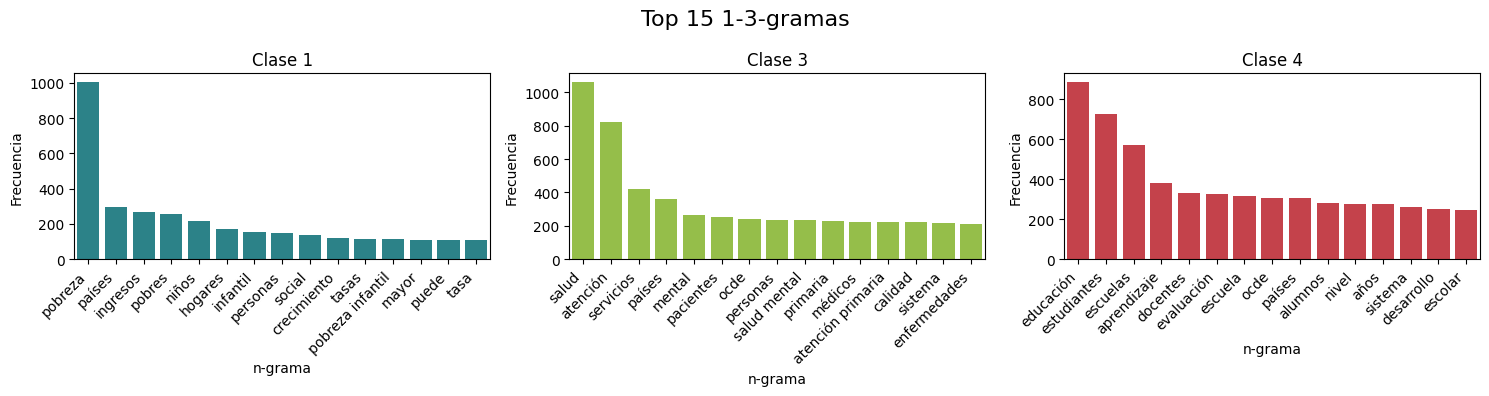

In [191]:
comparar_ngrams_por_clase((1, 3))

Solo se observan las mismas palabras que en un análisis de unigramas.


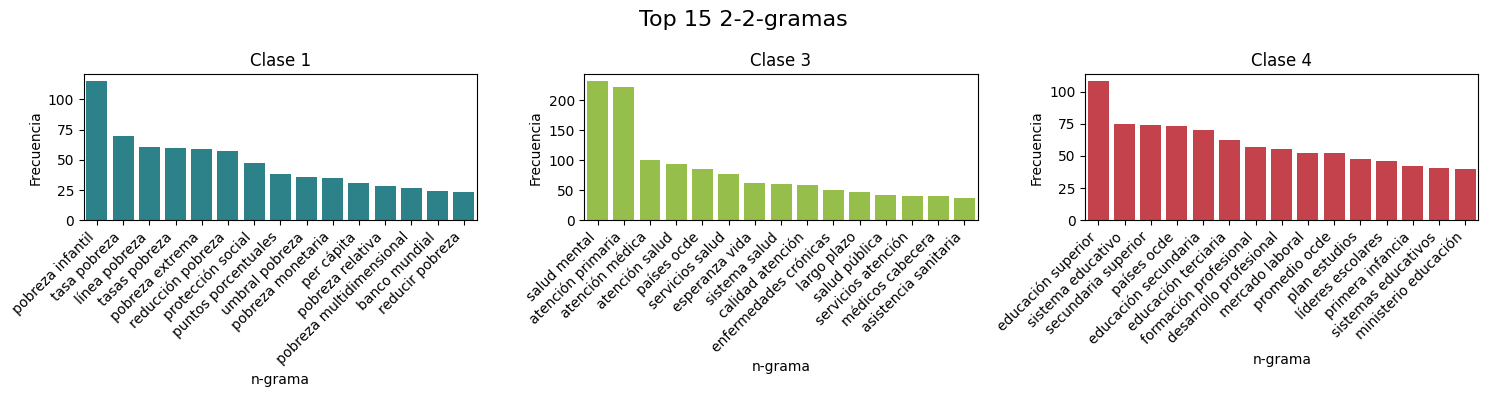

In [192]:
comparar_ngrams_por_clase((2, 2))

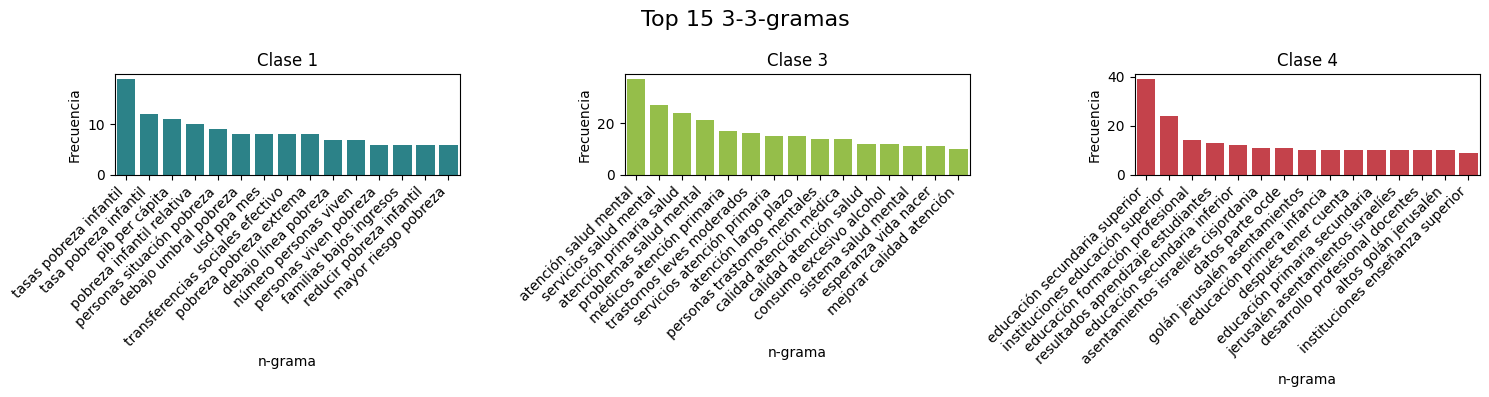

In [193]:
comparar_ngrams_por_clase((3, 3))

Estas tres versiones distintas de n-gramas (1-3-grama, 2-2 grama y 3-3 grama) permiten ver que un 1-3 n grama es el que más información relevante puede otorgar ya que se ve que cada una de estas (unigramas, bigramas y trigramas) presentan información relevante.


## 3.2 TF-IDF para extracción de features

El uso de TF-IDF (Term Frequency–Inverse Document Frequency) para extracción de features consiste en evaluar la importancia de una palabra con respecto a una mayor cantidad de documentos.
Para esto, se considera la frecuencia de término (_term frequency_ (TF)) la cual mide la cantidad de apariciones de una palabra $t$ dentro del documento $d$:

$ TF(t,d) = \frac{\# \, apariciones \, de \, t \,en\, d}{\#\, total\, de \,terminos\, en\, d}$

La otra parte que se utiliza dentro de este método es la frecuencia inversa de documento (IDF). Este parámetro tiene como fin reducir el peso de las palabras más comunes y asignarle un peso mayor a las palabras menos frecuentes. Esto debido, a que una palabra poco común puede tener un significado más importante y diferenciador frente al resto de términos. Para esto, se utiliza la formula:

$IDF(t, D) = log \frac{\# \,total\, de\, documentos \,en \,D}{\# \,documentos\, con\, el\, termino\, t}$

Para implementar este método se utilizó `sklearn` con TfidfVectorizer. Para configurar este método se utilizaron las 1000 palabras más comunes dentro de los datos de entrenamiento, un máximo de 1000 iteraciones y se utiliza ngram_range el cual permite agregar limites para utilizar diferentes n-gramas.


In [194]:
def tf_idf_extraction(X_train_text, vectorizer):

    # Aplicar tf-idf sobre la columna con el texto tokenizado
    tfidf_matrix = vectorizer.fit_transform(X_train_text)

    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=vectorizer.get_feature_names_out(),
        index=X_train_text.index,
    )
    final_df = tfidf_df
    return final_df, tfidf_matrix


def tf_idf_vectorizar(X_train_text):
    all_tokens = []
    for v in X_train_text:
        for w in v.split():
            all_tokens.append(w.strip())

    word_counts = Counter(all_tokens)

    n_words = 1000
    most_common_words = word_counts.most_common(n_words)
    top_words = [word for word, count in most_common_words]

    # Definir vectorizador TF-IDF sobre palabras más comunes
    vectorizer = TfidfVectorizer(vocabulary=top_words, ngram_range=(1, 3))
    return vectorizer


vectorizer = tf_idf_vectorizar(X_train_text)
final_df, tfidf_matrix = tf_idf_extraction(X_train_text, vectorizer)
display(final_df.head())

,salud,pobreza,educación,países,atención,estudiantes,ocde,escuelas,años,servicios,...,producción,uruguay,pequeños,supervisión,norte,unidades,tan,encuentra,significativas,informal
84,0.0,0.000000,0.000000,0.097541,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1828,0.0,0.000000,0.255467,0.121371,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.280813,0.000000,0.000000,0.0
1917,0.0,0.323388,0.000000,0.108728,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
974,0.0,0.000000,0.325996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.238893,0.000000,0.0
109,0.0,0.000000,0.000000,0.128951,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.150382,0.0


Para visualizar el resultado del uso de extracción de features con TD-IDF se genera una gráfica de las palabras con mayor valor por clase a partir del valor promedio de TD-IDF.


C:\Users\david\AppData\Local\Temp\ipykernel_36128\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")
C:\Users\david\AppData\Local\Temp\ipykernel_36128\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")
C:\Users\david\AppData\Local\Temp\ipykernel_36128\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")


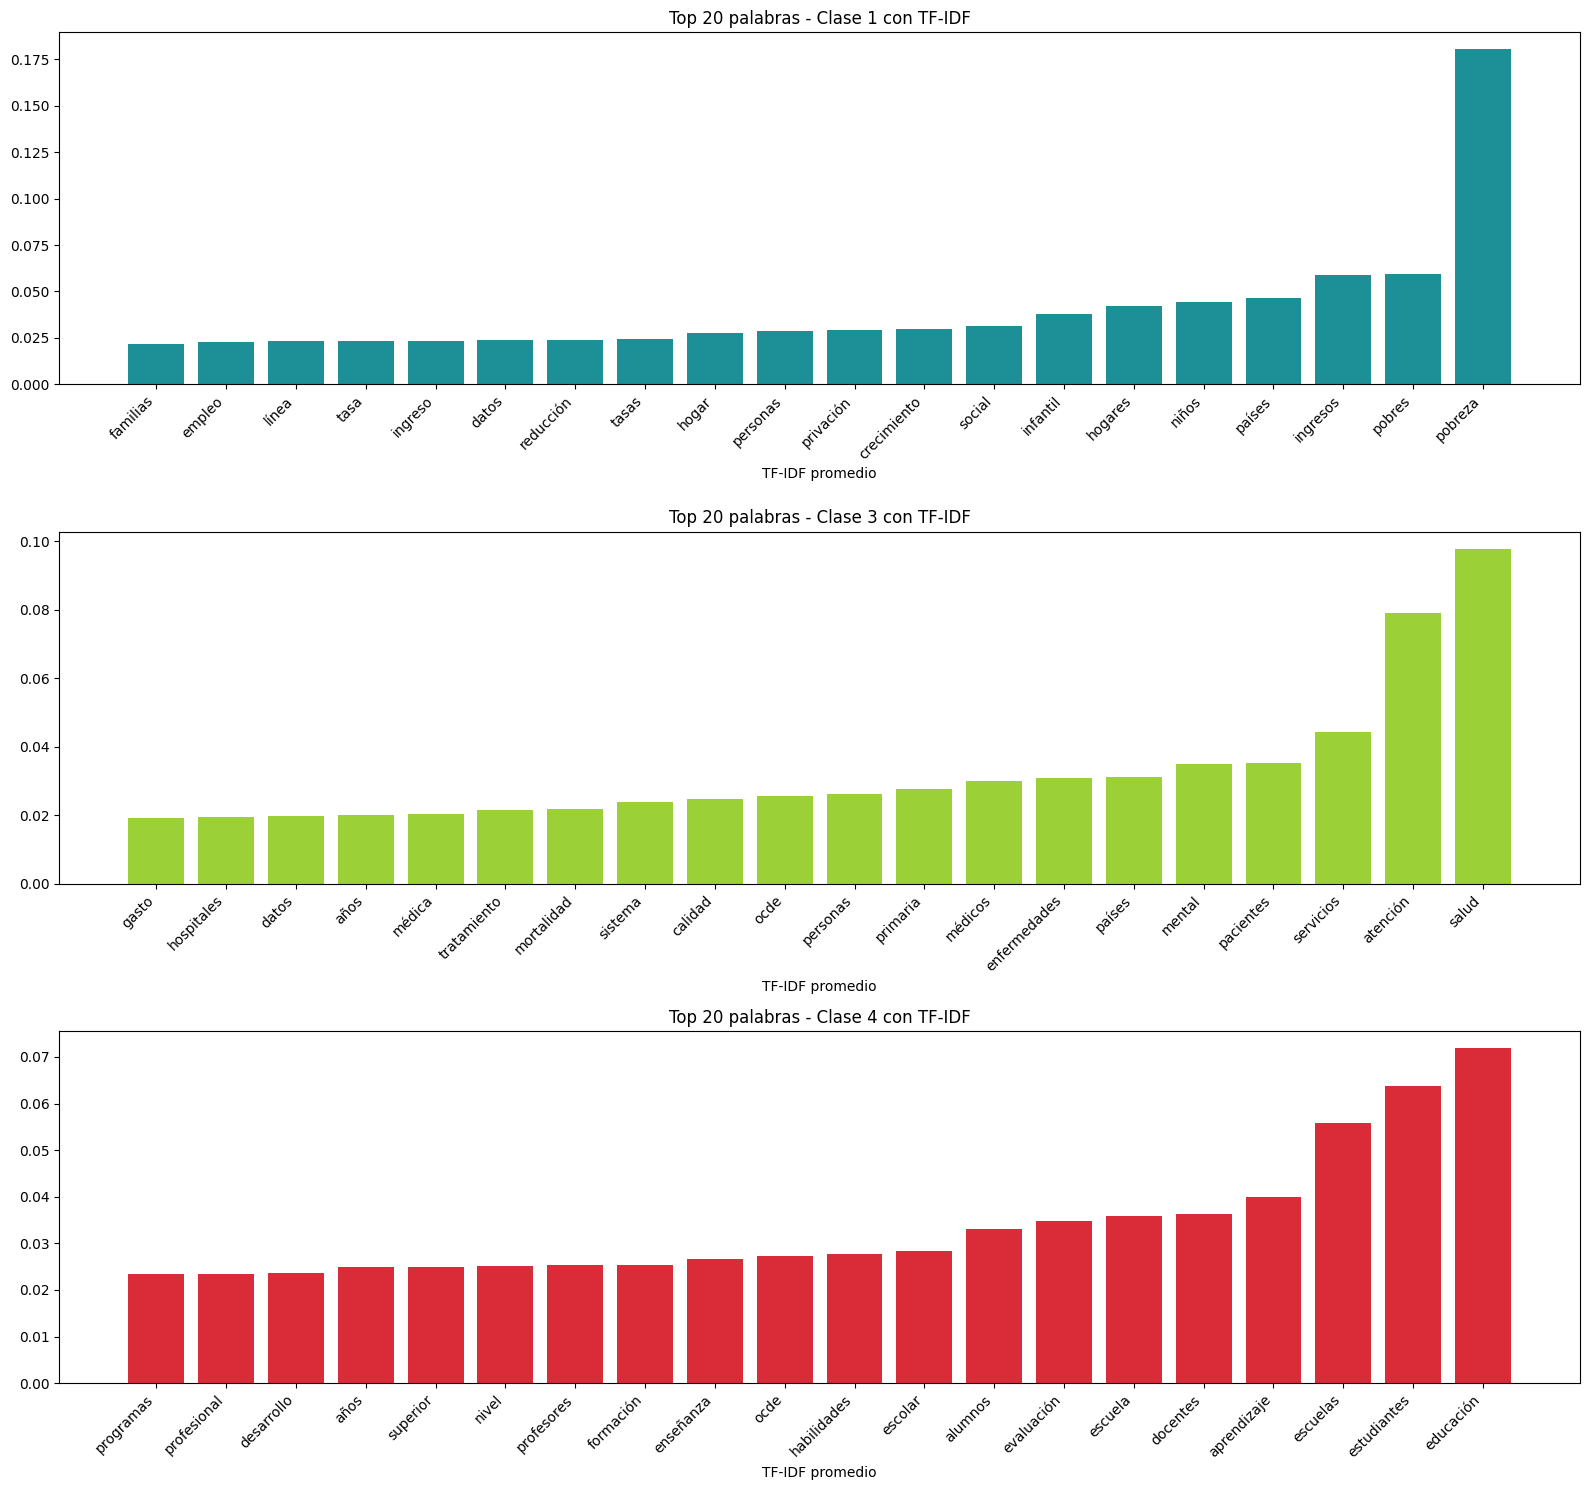

In [195]:
final_df = pd.concat([y_train, final_df], axis=1)
class_tfidf = final_df.groupby("labels").mean()

top_n = 20
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

for i, label in enumerate(class_tfidf.index):
    top_features = class_tfidf.loc[label].sort_values(ascending=False)[:top_n]
    axes[i].bar(
        top_features.index[::-1], top_features.values[::-1], color=colors[label]
    )
    axes[i].set_title(f"Top {top_n} palabras - Clase {label} con TF-IDF")
    axes[i].set_xlabel("TF-IDF promedio")
    axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")

plt.tight_layout()
plt.show()

## 3.3 Análisis con Document Similarity

Otra estrategia conocida para agrupar texto es el document similarity, que permite ver como se parecen las palabras entre si, muy útil para entrenar modelos no supervisados. Aunque este no es ese caso, si se desea estudiar esta estrategia para ver el comportamiento del texto, y ver cual va a ser su comportamiento general al momento de clasificarlo. Para esto se crea una matriz de similitud y luego se grafica.


In [196]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059
0,1.000000,0.067159,0.010605,0.000000,0.012578,0.041086,0.031606,0.034646,0.000000,0.027760,...,0.000000,0.000000,0.022447,0.019151,0.020954,0.027010,0.000000,0.000000,0.000000,0.018562
1,0.067159,1.000000,0.013196,0.102445,0.015651,0.000000,0.099070,0.000000,0.018298,0.028992,...,0.050298,0.000000,0.000000,0.000000,0.035891,0.114459,0.056206,0.029757,0.000000,0.027144
2,0.010605,0.013196,1.000000,0.051074,0.014020,0.000000,0.006718,0.009483,0.159531,0.008078,...,0.007164,0.016425,0.165251,0.006117,0.007466,0.014154,0.130997,0.000000,0.014429,0.057016
3,0.000000,0.102445,0.051074,1.000000,0.000000,0.000000,0.112480,0.050067,0.000000,0.042742,...,0.060900,0.049841,0.018886,0.015774,0.088281,0.099154,0.052803,0.037972,0.000000,0.034127
4,0.012578,0.015651,0.014020,0.000000,1.000000,0.000000,0.017327,0.011914,0.000000,0.042494,...,0.033955,0.036192,0.077313,0.017566,0.049910,0.000000,0.100672,0.000000,0.009929,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,0.027010,0.114459,0.014154,0.099154,0.000000,0.028939,0.019172,0.021154,0.000000,0.029168,...,0.010287,0.063719,0.085268,0.208979,0.087121,1.000000,0.108669,0.140914,0.000000,0.010903
2056,0.000000,0.056206,0.130997,0.052803,0.100672,0.000000,0.025737,0.009214,0.061239,0.059284,...,0.061712,0.026858,0.076568,0.074443,0.015475,0.108669,1.000000,0.109744,0.012636,0.000000
2057,0.000000,0.029757,0.000000,0.037972,0.000000,0.000000,0.000000,0.000000,0.022915,0.043346,...,0.221870,0.067006,0.109718,0.098455,0.036620,0.140914,0.109744,1.000000,0.024308,0.000000
2058,0.000000,0.000000,0.014429,0.000000,0.009929,0.064771,0.065652,0.012915,0.000000,0.000000,...,0.023010,0.009142,0.039242,0.022071,0.028933,0.000000,0.012636,0.024308,1.000000,0.021948


In [197]:
Z = linkage(similarity_matrix, "ward")
pd.DataFrame(
    Z,
    columns=[
        r"Document\Cluster 1",
        r"Document\Cluster 2",
        r"Distance",
        r"Cluster Size",
    ],
    dtype="object",
)

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,1764.0,1878.0,1.035062,2.0
1,907.0,1266.0,1.056715,2.0
2,134.0,740.0,1.124957,2.0
3,953.0,1794.0,1.133515,2.0
4,1023.0,1851.0,1.265204,2.0
...,...,...,...,...
2054,4107.0,4112.0,17.028965,832.0
2055,4108.0,4111.0,17.231274,365.0
2056,4110.0,4115.0,26.653788,888.0
2057,4114.0,4116.0,40.194508,1720.0


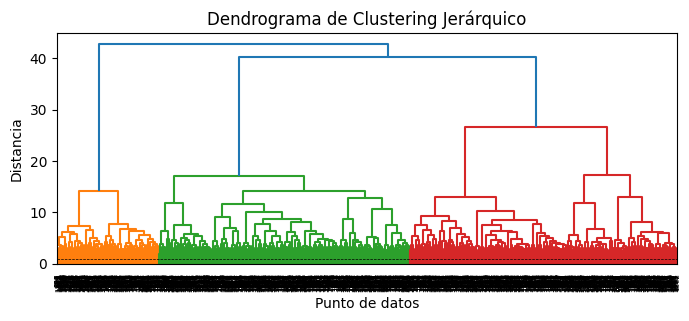

In [198]:
plt.figure(figsize=(8, 3))
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Punto de datos")
plt.ylabel("Distancia")
dendrogram(Z)
plt.axhline(y=1.0, c="k", ls="--", lw=0.5)

Este resultado señala que hay conexiones entre el texto, donde entre mas bajo se encuentren en el árbol, más se parecen entre si. Las partes naranjas/verdes en la parte inferior muestran documentos muy similares entre sí mientras que las conexiones rojas en la parte superior indican grupos más grandes pero menos cohesionados. La altura mayor de las conexiones rojas sugiere mayor disimilitud entre estos grupos.

Esto nos dice que existen algunos grupos pequeños de documentos muy similares (clusters bajos) y hay una clara estructura jerárquica con 3 grupos principales. Este primer acercamiento resulta muy coherente con la clasificación de 3 grupos ODS que deseamos hacer. Asimismo, la altura de las conexiones sugiere que los documentos dentro de cada grupo principal son relativamente similares entre sí, pero estas diferencias se marcan al aumentar la distancia, donde se observan los 3 grupos.

Esto nos dice que el dataset cuenta con diferencias lo suficientemente marcadas para buscar obtener una clasificación satisfactoria.


## 3.3 Word2Vec

Este método de extracción de features permite obtener vectores de representación para las palabras teniendo en cuenta que 2 palabras que comparten contextos similares, deben compartir un significado similar. Este modelo se utiliza para encontrar las relaciones entre palabras lo que permite depués generar representaciones vecotriales de documentos a partir de estos vectores de palabras. El método de _fonod_ utiliza una red neuronal y un clasificador softmax para generar los embeddings.
Para este caso se utiliza gensim para obtener los features.


In [199]:
def document_vector(doc, model):
    doc_new = []
    for word in doc:
        if word in model.wv.key_to_index:
            doc_new.append(word)
    if len(doc_new) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model.wv[doc_new], axis=0)


def generate_features_w2v(model, corpus):
    vectors = []
    for text in corpus:
        doc_vec = document_vector(text, model)
        vectors.append(doc_vec)
    return np.array(vectors)


def word2vec_function(X_train_text):
    corpus = []
    for text in X_train_text:
        corpus.append(text.split())
    model = Word2Vec(
        sentences=corpus,
        vector_size=200,
        window=3,
        min_count=5,
        alpha=0.04,
        min_alpha=0.005,
    )
    return model, corpus


model_w2v, corpus_w2v = word2vec_function(X_train_text)
X_word2vec = generate_features_w2v(model_w2v, corpus_w2v)
display(X_word2vec)

array([[ 0.09302689, -0.01723033, -0.04809499, ..., -0.17971554,
        -0.01334274, -0.06571925],
       [ 0.04497145, -0.03824807, -0.03519428, ..., -0.18192458,
        -0.04929426, -0.05916912],
       [ 0.14604409, -0.01597441, -0.10570325, ..., -0.20540792,
        -0.0155621 , -0.10708168],
       ...,
       [ 0.01379602, -0.00467252, -0.02921281, ..., -0.15977202,
        -0.08556732, -0.05241255],
       [ 0.05570656, -0.04833174, -0.04090625, ..., -0.18134975,
        -0.05454946, -0.06464836],
       [ 0.09007312, -0.03805697, -0.01662043, ..., -0.19227488,
         0.02473948, -0.05098932]], dtype=float32)

# 4. Modelos


## 4.1 Naïve Bayes Multinomial

Explorado por: Maria Alejandra Angulo Mejia

El algoritmo Multinomial Naïve Bayes es un clasificador probabilístico que parte del Teorema de Bayes. Suponiendo que las características (en este caso, las palabras) son independientes entre sí dentro de un documento, el modelo estima la probabilidad de que un texto pertenezca a una clase (por ejemplo, un ODS) a partir de la frecuencia con la que aparecen las palabras en ese texto y en los documentos de entrenamiento de cada categoría.

El término multinomial se debe a que este algoritmo funciona muy bien con variables de conteo, como el número de veces que aparece cada palabra. De esta forma, si una palabra es más común en documentos de cierta clase, el modelo le da más peso a esa relación.

Entre sus ventajas están su sencillez, rapidez y buen rendimiento en tareas de clasificación de texto, incluso cuando se trabaja con grandes volúmenes de datos y vocabularios extensos. No obstante, suponer que todas las palabras son independientes es una limitación, ya que en el lenguaje suele haber relaciones entre términos.

Para evaluar su desempeño, se realizan pruebas de clasificación usando representaciones como BoW, n-gramas (1-3 y 1-5) y TF-IDF, con base en el análisis previo. La expectativa es que los 1-3 Gramas ayuden a mitigar, en parte, la suposición de independencia propia de Naïve Bayes.


### 4.1.1 N-M-Gramas


In [200]:
def n_grama(n_grama_param):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test_text.fillna(""))
    # Modelo
    nb_ngram = MultinomialNB()
    nb_ngram.fit(X_train_ngram, y_train)
    y_pred_ngram = nb_ngram.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred_ngram, average="macro"))
    print("Precision:", precision_score(y_test, y_pred_ngram, average="macro"))
    print("Recall:", recall_score(y_test, y_pred_ngram, average="macro"))
    print(classification_report(y_test, y_pred_ngram))

In [201]:
n_grama((1, 1))

N-grama (1, 1):
F1 score: 0.9683040867335345
Precision: 0.9692099807261552
Recall: 0.9674285122469058
              precision    recall  f1-score   support

           1       0.95      0.94      0.94        82
           3       0.98      0.98      0.98       125
           4       0.98      0.99      0.98       157

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364



In [202]:
n_grama((1, 3))
print("===============================")
n_grama((1, 5))

N-grama (1, 3):
F1 score: 0.9421090066120493
Precision: 0.9517014878125988
Recall: 0.9354517114597897
              precision    recall  f1-score   support

           1       0.96      0.84      0.90        82
           3       0.95      0.98      0.96       125
           4       0.95      0.98      0.97       157

    accuracy                           0.95       364
   macro avg       0.95      0.94      0.94       364
weighted avg       0.95      0.95      0.95       364

N-grama (1, 5):
F1 score: 0.9484649122807017
Precision: 0.9610664722030807
Recall: 0.9402415203769872
              precision    recall  f1-score   support

           1       0.99      0.84      0.91        82
           3       0.95      0.99      0.97       125
           4       0.95      0.99      0.97       157

    accuracy                           0.96       364
   macro avg       0.96      0.94      0.95       364
weighted avg       0.96      0.96      0.96       364



### 4.1.2 TF-IDF


In [203]:
# Aplicar TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.90)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_text.fillna(""))
X_test_tfidf = vectorizer_tfidf.transform(X_test_text.fillna(""))

# Modelo
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

print("TF-IDF con vocabulario predefinido:")
print("F1 score:", f1_score(y_test, y_pred_tfidf, average="macro"))
print("Precision:", precision_score(y_test, y_pred_tfidf, average="macro"))
print("Recall:", recall_score(y_test, y_pred_tfidf, average="macro"))
print(classification_report(y_test, y_pred_tfidf))

TF-IDF con vocabulario predefinido:
F1 score: 0.9564575596033551
Precision: 0.9592988936112797
Recall: 0.9539650976127595
              precision    recall  f1-score   support

           1       0.94      0.91      0.93        82
           3       0.98      0.96      0.97       125
           4       0.96      0.99      0.97       157

    accuracy                           0.96       364
   macro avg       0.96      0.95      0.96       364
weighted avg       0.96      0.96      0.96       364



Después de realizar las cuatro pruebas, se puede concluir cuál es la forma de vectorización más adecuada para Multinomial Naïve Bayes. Al analizar las métricas de f1-score, precisión y recall, se observa que tanto BoW a partir de n-m gramas como TF-IDF ofrecen un desempeño muy alto y prácticamente equivalente.

BoW con unigramas alcanza un f1-score de 96.8%, una precisión de 96.70% y un recall de 96.7%, mientras que TF-IDF obtiene un f1-score de 95.6%, precisión de 95.9% y un recall de 95.4%. Estas diferencias son mínimas y confirman que ambas representaciones mantienen una proporcionalidad similar en el uso de las palabras, lo que lleva al modelo a comportarse casi igual en ambos casos.


## 4.2 Regresión Logística

Explorado por: Laura Sofia Murcia

La regresión logística es un modelo de aprendizaje supervisado de clasificación. Este es un modelo lineal similar a la regresión lineal, pero que genera una salida categórica; razón por la cual es aplicable a este problema.
Este modelo permite predecir la probabilidad de que un evento ocurra. Es decir, su método de clasificación es determinar que tan probable es cada evento de pertenecer a una clase.

La regresión logística multiclase se realiza usando una función _softmax_, la cual asigna probabilidades a cada clase. El modelo genera predicciones a partir de qué clase tiene la mayor probabilidad. La función _softmax_ sigue al formula:

$P(y=k) = \frac{e^{zk}}{\sum_j e^{zj}}$

En esta formula, $zk$ es el score de cada clase y se calcula sobre la suma de todos los scores de la clase para normalizar.

En particular, se utilizó el solver `saga` el cual según la documentación de la librería se adapta bien a modelos multiclases y se definen máximo 1000 iteraciones.


### 4.2.1 TF-IDF

Se realiza un modelo con el uso de logistic regression y se calculan sus métricas. Se utilizan los datos preparados con TF-IDF para esto.


In [204]:
vectorizer = tf_idf_vectorizar(X_train_text)
tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

log_reg = LogisticRegression(solver="saga", max_iter=1000, random_state=42)
log_reg.fit(tfidf_matrix_train, y_train)

pred_labels = log_reg.predict(tfidf_matrix_test)
f1_macro = f1_score(y_test, pred_labels, average="macro")
accuracy = precision_score(y_test, pred_labels, average="macro")
recall = recall_score(y_test, pred_labels, average="macro")

print("F1 score: ", f1_macro)
print("Precision: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, pred_labels))

F1 score:  0.9542479677293082
Precision:  0.9587649555169241
Recall:  0.9504435813784889
              precision    recall  f1-score   support

           1       0.96      0.90      0.93        82
           3       0.95      0.97      0.96       125
           4       0.96      0.98      0.97       157

    accuracy                           0.96       364
   macro avg       0.96      0.95      0.95       364
weighted avg       0.96      0.96      0.96       364



### 4.2.2 Word2Vec


In [205]:
model_w2v, corpus_w2v = word2vec_function(X_train_text)

X_train_w2v = generate_features_w2v(model_w2v, corpus_w2v)

corpus_test = []
for text in X_test_text:
    corpus_test.append(text.split())

X_test_w2v = generate_features_w2v(model_w2v, corpus_test)


# Modelo
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_w2v, y_train)

# Evaluación
y_pred = clf.predict(X_test_w2v)
f1_macro = f1_score(y_test, y_pred, average="macro")
accuracy = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
print("F1 score: ", f1_macro)
print("Precision: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, y_pred))

F1 score:  0.8838677393279187
Precision:  0.8828134231360037
Recall:  0.8850172440577909
              precision    recall  f1-score   support

           1       0.81      0.83      0.82        82
           3       0.87      0.86      0.87       125
           4       0.97      0.96      0.96       157

    accuracy                           0.90       364
   macro avg       0.88      0.89      0.88       364
weighted avg       0.90      0.90      0.90       364



### 4.2.3 N-M-Gramas


In [ ]:
def logistic_n_gram(n_grama_param, X_train, X_test, y_train, y_test):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test.fillna(""))

    # Modelo
    log_n = LogisticRegression(solver="saga", max_iter=1000, random_state=42)
    log_n.fit(X_train_ngram, y_train)
    y_pred = log_n.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred, average="macro"))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))

logistic_n_gram((1, 1), X_train_text, X_test_text, y_train, y_test)
print("===============================")
logistic_n_gram((1, 3), X_train_text, X_test_text, y_train, y_test)
print("===============================")
logistic_n_gram((1, 5), X_train_text, X_test_text, y_train, y_test)

N-grama (1, 3):
F1 score: 0.9649232241670429
Precision: 0.967890163787068
Recall: 0.9625086220288953
              precision    recall  f1-score   support

           1       0.96      0.91      0.94        82
           3       0.96      0.99      0.98       125
           4       0.98      0.98      0.98       157

    accuracy                           0.97       364
   macro avg       0.97      0.96      0.96       364
weighted avg       0.97      0.97      0.97       364

N-grama (1, 5):
F1 score: 0.9557460380743547
Precision: 0.9608560490006646
Recall: 0.9517118740614157
              precision    recall  f1-score   support

           1       0.96      0.89      0.92        82
           3       0.95      0.98      0.97       125
           4       0.97      0.98      0.97       157

    accuracy                           0.96       364
   macro avg       0.96      0.95      0.96       364
weighted avg       0.96      0.96      0.96       364



Se observan desempeños similares al modelo de Naïve Bayes Multinomial, especialmente al representar los datos con TF-IDF y n-m gramas. Sin embargo, la regresión logística muestra una ligera disminución en las métricas de precisión, recall y f1-score en comparación con Naïve Bayes Multinomial.


## 4.3 Arboles de Decisión

Explorado por: David Tobón Molina

Los árboles de decisión son modelos de aprendizaje supervisado que se utilizan tanto para tareas de clasificación como de regresión. Estos modelos funcionan dividiendo los datos en subconjuntos basados en características específicas, creando una estructura similar a un árbol donde cada nodo representa una característica o grupos de características y cada rama representa una decisión basada en esa característica. El objetivo es llegar a una hoja del árbol que represente la predicción final.

En cada nodo, el árbol selecciona la característica que mejor separa los datos en función de un criterio de división, en este caso, el criterio de Gini:

$Gini = 1 - \sum_{i=1}^{C} p_i^2$

Donde:

- C es el número de clases.
- $p_i$ es la proporción de instancias de la clase i en el nodo.

Este criterio mide la impureza de un conjunto de datos, es decir, qué tan mezcladas están las clases en ese conjunto. El árbol busca minimizar esta impureza en cada división, lo que ayuda a crear nodos que son lo más homogéneos posible en términos de la clase objetivo.

Los árboles de decisión cuentas con ventajas como su facilidad de interpretación y no requerir normalización de datos, pero tienen limitaciones como su tendencia al sobreajuste y su sensibilidad a pequeñas variaciones en los datos. Es por esto que se realizará un GridSearch y análisis de validación cruzada adicional para encontrar los mejores hiperparámetros y evaluar su desempeño o considerar el uso de un model de ensamble como Random Forest.


### 4.3.1 TF-IDF


In [207]:
tree = DecisionTreeClassifier(random_state=42, max_depth=20)

tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

tree.fit(tfidf_matrix_train, y_train)

tree_preds = tree.predict(tfidf_matrix_test)

print(f"Decision Tree con TF IDF:")
print("F1 score:", f1_score(y_test, tree_preds, average="macro"))
print("Precision:", precision_score(y_test, tree_preds, average="macro"))
print("Recall:", recall_score(y_test, tree_preds, average="macro"))
print(classification_report(y_test, tree_preds))

Decision Tree con TF IDF:
F1 score: 0.9038040760190048
Precision: 0.9061876662495858
Recall: 0.9024665734555435
              precision    recall  f1-score   support

           1       0.88      0.84      0.86        82
           3       0.88      0.94      0.91       125
           4       0.95      0.93      0.94       157

    accuracy                           0.91       364
   macro avg       0.91      0.90      0.90       364
weighted avg       0.91      0.91      0.91       364



Se observan métricas de desempeño más bajas en comparación con los modelos anteriores al entrenar el modelo sin una selección adecuada de hiperparámetros.


In [208]:
param_grid = {
    "max_depth": [5, 10, 15, 20, 25, 30, 35],
    "min_samples_split": [2, 5, 8, 10],
    "max_features": ["sqrt", None],
}

tree_base = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=tree_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",  # Métrica para optimizar
    n_jobs=-1,  # Usar todos los cores disponibles
)

tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

grid_search.fit(tfidf_matrix_train, y_train)

best_tree_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n=== MEJORES HIPERPARÁMETROS ===")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"\nMejor score de cross-validation: {grid_search.best_score_:.4f}")

tree_preds = best_tree_model.predict(tfidf_matrix_test)

print(f"\n=== RESULTADOS DEL MEJOR MODELO ===")
print(f"Decision Tree con TF-IDF (Optimizado):")
print("F1 score:", f1_score(y_test, tree_preds, average="macro"))
print("Precision:", precision_score(y_test, tree_preds, average="macro"))
print("Recall:", recall_score(y_test, tree_preds, average="macro"))
print("\n", classification_report(y_test, tree_preds))

final_tree_model = best_tree_model


=== MEJORES HIPERPARÁMETROS ===
max_depth: 25
max_features: None
min_samples_split: 10

Mejor score de cross-validation: 0.9129

=== RESULTADOS DEL MEJOR MODELO ===
Decision Tree con TF-IDF (Optimizado):
F1 score: 0.8993833929317576
Precision: 0.8973015873015874
Recall: 0.9021040857542334

               precision    recall  f1-score   support

           1       0.85      0.87      0.86        82
           3       0.90      0.94      0.92       125
           4       0.95      0.90      0.93       157

    accuracy                           0.91       364
   macro avg       0.90      0.90      0.90       364
weighted avg       0.91      0.91      0.91       364



No se observan mejoras significativas al ajustar hiperparámetros como la profundidad máxima del árbol y el número mínimo de muestras para dividir un nodo. Esto sugiere que el modelo de árbol de decisión puede no ser el más adecuado para este conjunto de datos, posiblemente debido a su tendencia a sobreajustar y la naturaleza compleja del texto. Inclusive, el desempeño es similar al árbol entrenado sin optimización de hiperparámetros.


### 4.3.2 N-M-Gramas


In [209]:
# 1, 1
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 1))
X_train_ngram = vectorizer.fit_transform(X_train_text.fillna(""))
X_test_ngram = vectorizer.transform(X_test_text.fillna(""))

tree = DecisionTreeClassifier(random_state=42, max_depth=30, min_samples_split=2)
tree.fit(X_train_ngram, y_train)
tree_preds = tree.predict(X_test_ngram)

print(f"Decision Tree N-grama(1,1):")
print("F1 score:", f1_score(y_test, tree_preds, average="macro"))
print("Precision:", precision_score(y_test, tree_preds, average="macro"))
print("Recall:", recall_score(y_test, tree_preds, average="macro"))
print(classification_report(y_test, tree_preds))

# 1, 3
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3))
X_train_ngram = vectorizer.fit_transform(X_train_text.fillna(""))
X_test_ngram = vectorizer.transform(X_test_text.fillna(""))

tree = DecisionTreeClassifier(random_state=42, max_depth=30, min_samples_split=2)
tree.fit(X_train_ngram, y_train)
tree_preds = tree.predict(X_test_ngram)

print(f"Decision Tree N-grama(1,3):")
print("F1 score:", f1_score(y_test, tree_preds, average="macro"))
print("Precision:", precision_score(y_test, tree_preds, average="macro"))
print("Recall:", recall_score(y_test, tree_preds, average="macro"))
print(classification_report(y_test, tree_preds))

# 1, 5
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 5))
X_train_ngram = vectorizer.fit_transform(X_train_text.fillna(""))
X_test_ngram = vectorizer.transform(X_test_text.fillna(""))

tree = DecisionTreeClassifier(random_state=42, max_depth=30, min_samples_split=2)
tree.fit(X_train_ngram, y_train)
tree_preds = tree.predict(X_test_ngram)

print(f"Decision Tree N-grama(1, 5):")
print("F1 score:", f1_score(y_test, tree_preds, average="macro"))
print("Precision:", precision_score(y_test, tree_preds, average="macro"))
print("Recall:", recall_score(y_test, tree_preds, average="macro"))
print(classification_report(y_test, tree_preds))

Decision Tree N-grama(1,1):
F1 score: 0.9069532545142301
Precision: 0.9065841887781336
Recall: 0.9073864636735539
              precision    recall  f1-score   support

           1       0.87      0.87      0.87        82
           3       0.91      0.92      0.91       125
           4       0.95      0.94      0.94       157

    accuracy                           0.91       364
   macro avg       0.91      0.91      0.91       364
weighted avg       0.92      0.91      0.91       364

Decision Tree N-grama(1,3):
F1 score: 0.9173344017094017
Precision: 0.9198298595983895
Recall: 0.9155677075242089
              precision    recall  f1-score   support

           1       0.90      0.85      0.88        82
           3       0.90      0.94      0.92       125
           4       0.96      0.95      0.96       157

    accuracy                           0.93       364
   macro avg       0.92      0.92      0.92       364
weighted avg       0.93      0.93      0.93       364

Decision T

Al cambiar el método de extracción de features a n-m gramas, se observa una ligera mejora en las métricas de desempeño del modelo de árbol de decisión. Sin embargo, estas mejoras siguen siendo modestas y el rendimiento general del modelo continúa siendo inferior al de los modelos de Naïve Bayes Multinomial y Regresión Logística.


### 4.3.3 Modelo ensamble: Random Forest

Dadas las bajas métricas obtenidas con el modelo de árbol de decisión, se propone utilizar un modelo de ensamble como Random Forest. Este modelo combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste. Random Forest crea varios árboles de decisión utilizando diferentes subconjuntos de datos y características, y luego promedia las predicciones de estos árboles para obtener una predicción final más robusta.


In [210]:
# LA CELDA SE DEMORA ALREDEDOR DE 8 MINUTOS EN CORRER

param_grid = {
    "n_estimators": [30, 50, 100, 150],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt"],
    "bootstrap": [True, False],
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
)

grid_search_rf.fit(tfidf_matrix_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_rf_model = grid_search_rf.best_estimator_
best_params = grid_search_rf.best_params_

print("\n=== MEJORES HIPERPARÁMETROS ===")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"\nMejor score de cross-validation: {grid_search_rf.best_score_:.4f}")

rf_preds_optimized = best_rf_model.predict(tfidf_matrix_test)

print(f"\n=== RESULTADOS DEL MEJOR MODELO ===")
print(f"Random Forest con TF-IDF (Optimizado):")
print("F1 score:", f1_score(y_test, rf_preds_optimized, average="macro"))
print("Precision:", precision_score(y_test, rf_preds_optimized, average="macro"))
print("Recall:", recall_score(y_test, rf_preds_optimized, average="macro"))
print("\n", classification_report(y_test, rf_preds_optimized))

final_rf_model = best_rf_model


=== MEJORES HIPERPARÁMETROS ===
bootstrap: False
max_depth: 30
max_features: sqrt
min_samples_split: 10
n_estimators: 150

Mejor score de cross-validation: 0.9594

=== RESULTADOS DEL MEJOR MODELO ===
Random Forest con TF-IDF (Optimizado):
F1 score: 0.949814759048308
Precision: 0.9539726357238149
Recall: 0.9463785407280824

               precision    recall  f1-score   support

           1       0.95      0.89      0.92        82
           3       0.95      0.97      0.96       125
           4       0.97      0.98      0.97       157

    accuracy                           0.96       364
   macro avg       0.95      0.95      0.95       364
weighted avg       0.96      0.96      0.96       364



Los resultados obtenidos con Random Forest muestran una mejora significativa en las métricas de desempeño en comparación con el modelo de árbol de decisión individual. Sin embargo, el rendimiento sigue siendo inferior al de los modelos de Naïve Bayes Multinomial y Regresión Logística.


# 5. Recopilación de resultados


In [217]:
def train_models(X_train, X_test, y_train, y_test):
    """
    Entrena Naive Bayes, Regresión Logística y Random Forest.
    """

    results = {}

    # Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_preds = nb_model.predict(X_test)

    results["NB"] = {
        "model": nb_model,
        "predictions": nb_preds,
        "f1_score": f1_score(y_test, nb_preds, average="macro"),
        "precision": precision_score(y_test, nb_preds, average="macro"),
        "recall": recall_score(y_test, nb_preds, average="macro"),
    }

    # Regresión Logística
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)

    results["LR"] = {
        "model": lr_model,
        "predictions": lr_preds,
        "f1_score": f1_score(y_test, lr_preds, average="macro"),
        "precision": precision_score(y_test, lr_preds, average="macro"),
        "recall": recall_score(y_test, lr_preds, average="macro"),
    }

    # Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=30,
        max_features="sqrt",
        random_state=42,
        min_samples_split=10,
        n_jobs=-1,
    )
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)

    results["RF"] = {
        "model": rf_model,
        "predictions": rf_preds,
        "f1_score": f1_score(y_test, rf_preds, average="macro"),
        "precision": precision_score(y_test, rf_preds, average="macro"),
        "recall": recall_score(y_test, rf_preds, average="macro"),
    }

    print(f"Naive Bayes F1-score: {results['NB']['f1_score']:.4f}")
    print(f"Regresión Logística F1-score: {results['LR']['f1_score']:.4f}")
    print(f"Random Forest F1-score: {results['RF']['f1_score']:.4f}")

    reports_dict = {
        "NB": classification_report(y_test, nb_preds, output_dict=True),
        "LR": classification_report(y_test, lr_preds, output_dict=True),
        "RF": classification_report(y_test, rf_preds, output_dict=True),
    }

    return results, reports_dict

In [245]:

def plot_f1_scores(
    results_tfidf, results_ngram, reports_tfidf=None, reports_ngram=None
):
    """
    Crea gráficos comparativos de F1-scores para todos los modelos y conjuntos de características.
    Incluye análisis específico para la clase minoritaria (clase 1).
    """
    print("\n=== CREANDO GRÁFICOS DE F1-SCORES ===")

    # Preparar datos para el gráfico
    models = list(results_tfidf.keys())
    tfidf_scores = [results_tfidf[model]["f1_score"] for model in models]
    ngram_scores = [results_ngram[model]["f1_score"] for model in models]

    # Crear el gráfico principal (tu código existente)
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))

    bars1 = ax.bar(
        x - width / 2, tfidf_scores, width, label="TF-IDF", alpha=0.8, color="#0b4944"
    )
    bars2 = ax.bar(
        x + width / 2,
        ngram_scores,
        width,
        label="Unigramas",
        alpha=0.8,
        color="#aeea00",
    )

    # Personalizar el gráfico
    ax.set_xlabel("Modelos", fontsize=12)
    ax.set_ylabel("F1-Score (Macro)", fontsize=12)
    ax.set_title(
        "Comparación de F1-Scores por Modelo y Tipo de Características",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Añadir valores en las barras
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.005,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.tight_layout()
    plt.show()

    if reports_tfidf and reports_ngram:
        print("\n=== ANÁLISIS DE LA CLASE MINORITARIA (CLASE 1) ===")

        # Extraer métricas de clase 1
        class1_precision_tfidf = []
        class1_recall_tfidf = []

        class1_precision_ngram = []
        class1_recall_ngram = []

        for model in models:
            # Para TF-IDF
            class1_precision_tfidf.append(reports_tfidf[model]["1"]["precision"])
            class1_recall_tfidf.append(reports_tfidf[model]["1"]["recall"])

            # Para N-gramas
            class1_precision_ngram.append(reports_ngram[model]["1"]["precision"])
            class1_recall_ngram.append(reports_ngram[model]["1"]["recall"])

        # Crear gráfico para clase 1
        fig, ax = plt.subplots(figsize=(14, 8))

        # Configurar posiciones de las barras
        x = np.arange(len(models))
        width = 0.2

        # TF-IDF
        bars1 = ax.bar(
            x - width * 1.5,
            class1_precision_tfidf,
            width,
            label="Precision TF-IDF",
            color="#0b4944",
            alpha=0.8,
        )
        bars2 = ax.bar(
            x - width * 0.5,
            class1_recall_tfidf,
            width,
            label="Recall TF-IDF",
            color="#0b4944",
            alpha=0.5,
        )

        # N-gramas
        bars3 = ax.bar(
            x + width * 0.5,
            class1_precision_ngram,
            width,
            label="Precision Unigramas",
            color="#aeea00",
            alpha=0.8,
        )
        bars4 = ax.bar(
            x + width * 1.5,
            class1_recall_ngram,
            width,
            label="Recall Unigramas",
            color="#aeea00",
            alpha=0.5,
        )

        ax.set_xlabel("Modelos", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_title(
            "Precision y Recall para Clase 1 (Clase Minoritaria - ODS 1)",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)

        # Añadir valores en las barras
        for bars in [bars1, bars2, bars3, bars4]:
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + 0.01,
                    f"{height:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

        plt.tight_layout()
        plt.show()
                
        # SOLO CON LR:
        # Crear gráfico para clase 1
        fig, ax = plt.subplots(figsize=(10, 6))

        class1_precision_tfidf = reports_tfidf["LR"]["1"]["precision"]
        class1_recall_tfidf = reports_tfidf["LR"]["1"]["recall"]

        class1_precision_ngram = reports_ngram["LR"]["1"]["precision"]
        class1_recall_ngram = reports_ngram["LR"]["1"]["recall"]

        # Configurar posiciones de las barras
        metrics = ['Precision', 'Recall']
        x = np.arange(len(metrics))
        width = 0.35

        # Datos para graficar
        tfidf_values = [class1_precision_tfidf, class1_recall_tfidf]
        ngram_values = [class1_precision_ngram, class1_recall_ngram]

        bars1 = ax.bar(
            x - width/2,
            tfidf_values,
            width,
            label="TF-IDF",
            color="#0b4944",
            alpha=0.8,
        )
        bars2 = ax.bar(
            x + width/2,
            ngram_values,
            width,
            label="Unigramas",
            color="#aeea00",
            alpha=0.8,
        )

        ax.set_xlabel("Métricas", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_title(
            "Precision y Recall para Clase 1 - Logistic Regression",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)

        # Añadir valores en las barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + 0.01,
                    f"{height:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                )

        plt.tight_layout()
        plt.show()
        

    print("\n=== TABLA DE RESULTADOS DETALLADOS ===")

    results_df = pd.DataFrame(
        {
            "Modelo": models + models,
            "Características": ["TF-IDF"] * len(models) + ["Unigramas"] * len(models),
            "F1-Score": tfidf_scores + ngram_scores,
            "Precision": [results_tfidf[model]["precision"] for model in models]
            + [results_ngram[model]["precision"] for model in models],
            "Recall": [results_tfidf[model]["recall"] for model in models]
            + [results_ngram[model]["recall"] for model in models],
        }
    )

    print(results_df.round(4))

    # Gráfico de métricas múltiples (tu código existente)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    metrics = ["F1-Score", "Precision", "Recall"]

    for i, metric in enumerate(metrics):
        x = np.arange(len(models))
        tfidf_values = [
            results_tfidf[model][metric.lower().replace("-", "_")] for model in models
        ]
        ngram_values = [
            results_ngram[model][metric.lower().replace("-", "_")] for model in models
        ]

        bars1 = axes[i].bar(
            x - width / 2,
            tfidf_values,
            width,
            label="TF-IDF",
            alpha=0.8,
            color="#0b4944",
        )
        bars2 = axes[i].bar(
            x + width / 2,
            ngram_values,
            width,
            label="Unigramas",
            alpha=0.8,
            color="#aeea00",
        )

        axes[i].set_xlabel("Modelos")
        axes[i].set_ylabel(metric)
        axes[i].set_title(f"Comparación de {metric}")
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(models, rotation=45)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

        # Añadir valores en las barras
        for bar in bars1 + bars2:
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.005,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

    return results_df

In [246]:
print("Con TF-IDF")
results_tfidf, reports_tfidf = train_models(
    tfidf_matrix_train, tfidf_matrix_test, y_train, y_test
)

vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train_ngram = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
X_test_ngram = vectorizer_ngram.transform(X_test_text.fillna(""))

print("BoW - Unigrama")
results_ngram, reports_ngram = train_models(
    X_train_ngram, X_test_ngram, y_train, y_test
)

Con TF-IDF
Naive Bayes F1-score: 0.9565
Regresión Logística F1-score: 0.9542
Random Forest F1-score: 0.9390
BoW - Unigrama
Naive Bayes F1-score: 0.9683
Regresión Logística F1-score: 0.9712
Random Forest F1-score: 0.9510



=== CREANDO GRÁFICOS DE F1-SCORES ===


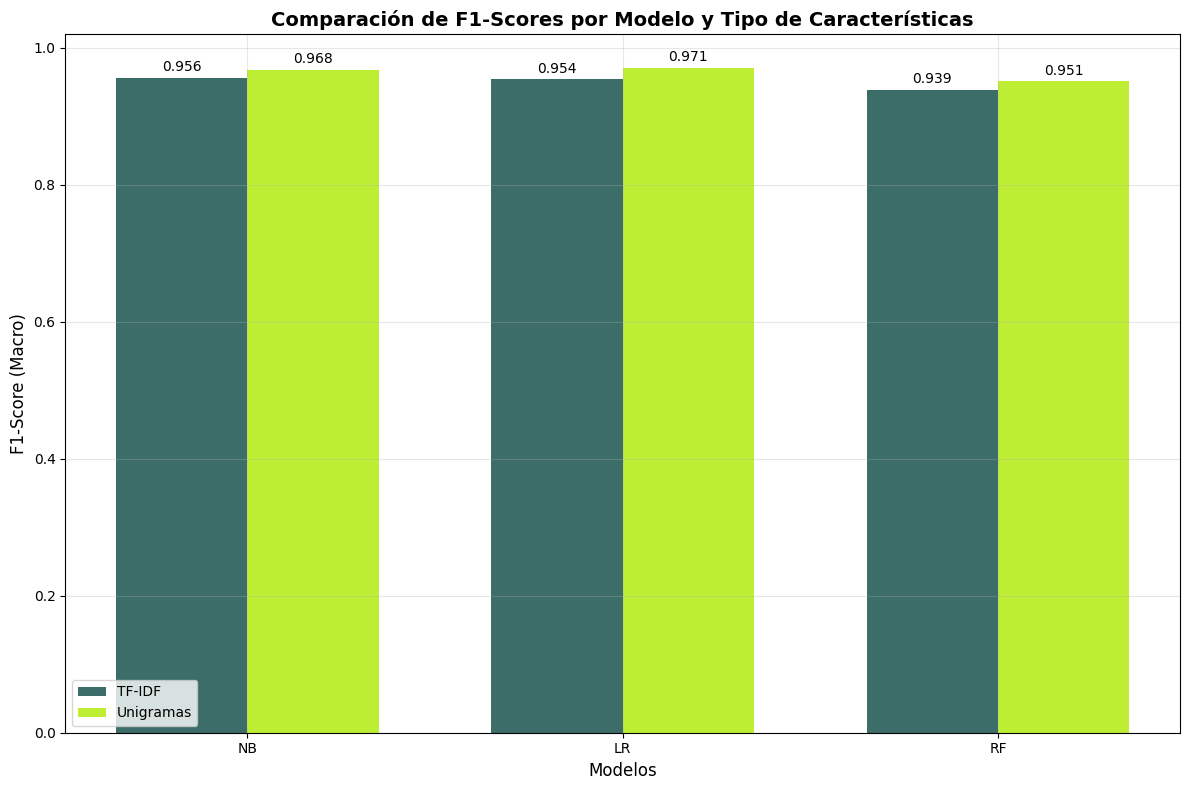


=== ANÁLISIS DE LA CLASE MINORITARIA (CLASE 1) ===


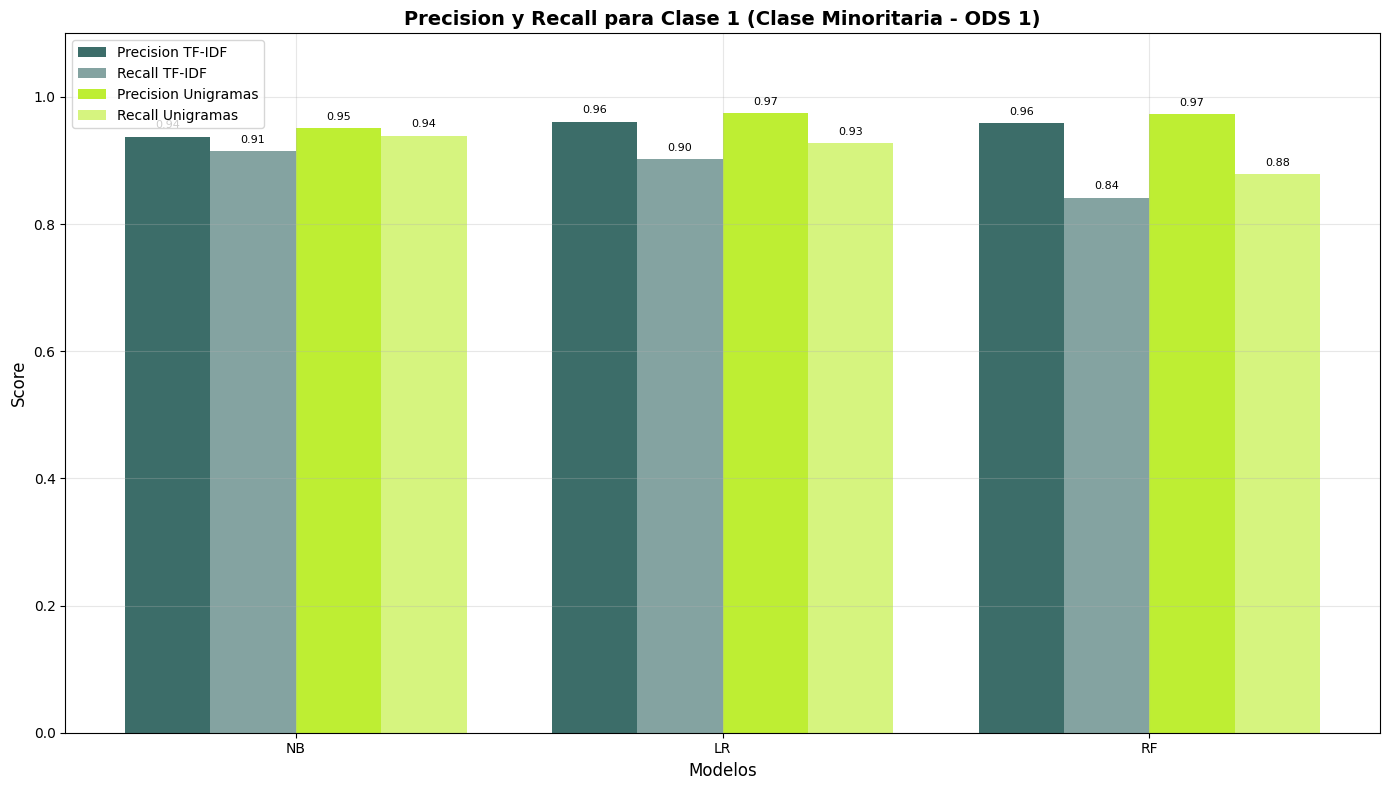

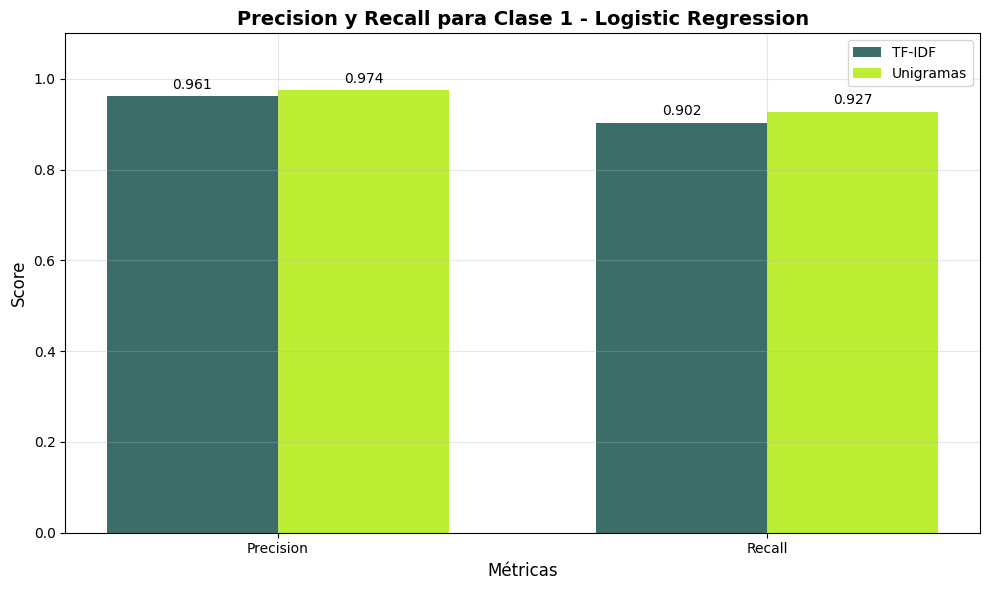


=== TABLA DE RESULTADOS DETALLADOS ===
  Modelo Características  F1-Score  Precision  Recall
0     NB          TF-IDF    0.9565     0.9593  0.9540
1     LR          TF-IDF    0.9542     0.9588  0.9504
2     RF          TF-IDF    0.9390     0.9486  0.9322
3     NB       Unigramas    0.9683     0.9692  0.9674
4     LR       Unigramas    0.9712     0.9743  0.9687
5     RF       Unigramas    0.9510     0.9589  0.9450


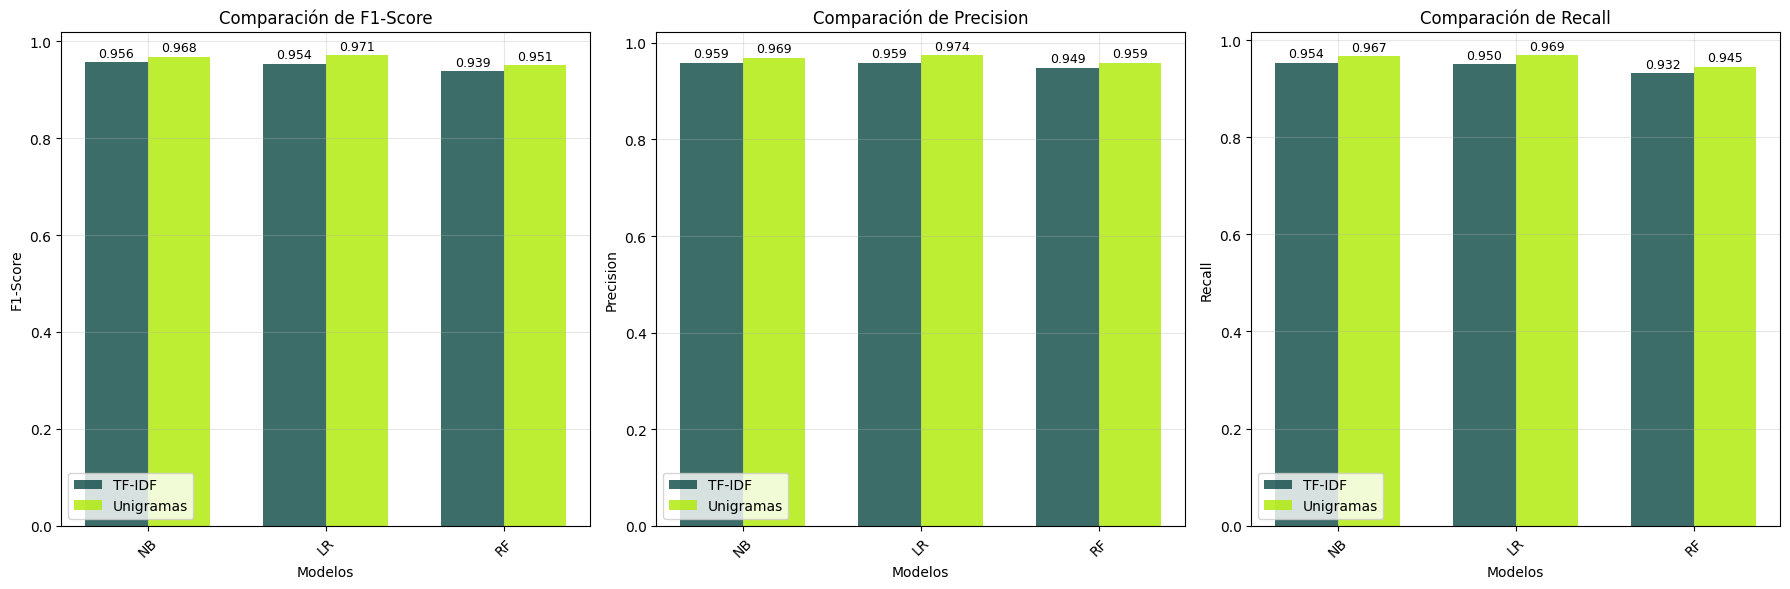

,Modelo,Características,F1-Score,Precision,Recall
0,NB,TF-IDF,0.956458,0.959299,0.953965
1,LR,TF-IDF,0.954248,0.958765,0.950444
2,RF,TF-IDF,0.938970,0.948631,0.932242
3,NB,Unigramas,0.968304,0.969210,0.967429
4,LR,Unigramas,0.971213,0.974287,0.968697
5,RF,Unigramas,0.951007,0.958905,0.944980


In [247]:
plot_f1_scores(results_tfidf, results_ngram, reports_tfidf, reports_ngram)

In [248]:
vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
X_test = vectorizer_ngram.transform(X_test_text.fillna(""))

best_model = LogisticRegression(max_iter=1000, random_state=42)

best_model.fit(X_train, y_train)

y_preds = best_model.predict(X_test)

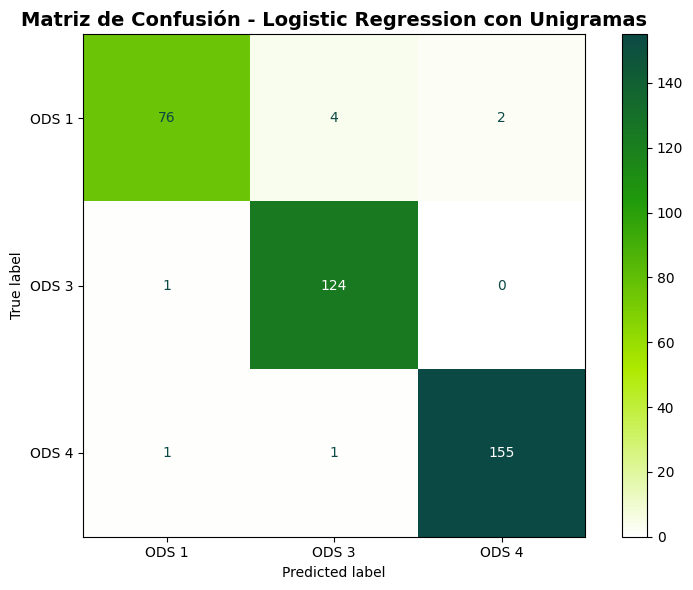

In [265]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

cm = confusion_matrix(y_test, y_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [262]:
from sklearn.model_selection import cross_val_score

# validación cruzada con 10 folds
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1_macro')
cv_scores_precision = cross_val_score(best_model, X_train, y_train, cv=10, scoring='precision_macro')
cv_scores_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall_macro')

print("10-Fold Cross Validation Results:")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
print(f"Recall: {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")

10-Fold Cross Validation Results:
F1-Score: 0.9715 (+/- 0.0273)
Precision: 0.9748 (+/- 0.0248)
Recall: 0.9687 (+/- 0.0303)


# 6. Entrenamiento del modelo sobre todo el dataset

In [263]:
vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train_all = vectorizer_ngram.fit_transform(X.fillna(""))

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_all, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# 7. Inferencia sobre nuevos datos

In [264]:
test_df = pd.read_excel(r"Datos de prueba_proyecto.xlsx")

normalized_test_df = test_df.copy()
normalized_test_df[["tokenized_text", "tokens"]] = normalized_test_df["Textos_espanol"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

X_test = normalized_test_df['tokenized_text']

X_test = vectorizer_ngram.transform(X_test)

test_preds = model.predict(X_test)

normalized_test_df["labels"] = test_preds

final_df = normalized_test_df[["Textos_espanol", "labels"]]
final_df.to_excel(r"Datos de prueba_proyecto.xlsx", index=False)
